In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import datetime as dt
from pandas.plotting import table

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

C:\Users\Julie\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


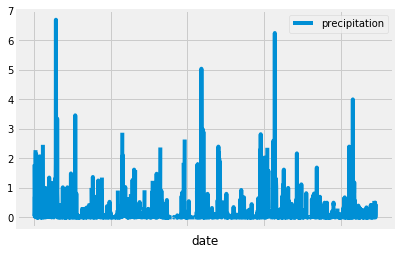

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
prior_yr = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prior_yr).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
results_df = pd.DataFrame(results, columns=['date', 'precipitation'])
results_df.set_index(results_df['date'], inplace=True)

# Sort the dataframe by date
results_df = results_df.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
results_df.plot()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
results_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(func.count(Station.station)).all()
num_stations

[(9)]

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

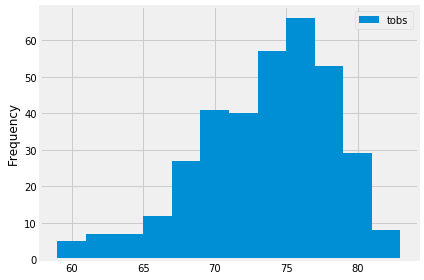

In [26]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

prior_year = dt.date(2017,8, 23) - dt.timedelta(days=365)

results = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date >= prior_year).all()
temp_df = pd.DataFrame(results, columns=['tobs'])
temp_df.plot.hist(bins=12)
plt.tight_layout()

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2016-10-22', '2016-10-31'))

[(68.0, 76.15625, 81.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
import datetime as dt

prev_year_start = dt.date(2016, 10, 22) - dt.timedelta(days=365)
prev_year_end = dt.date(2016, 10, 31) - dt.timedelta(days=365)

tmin, tavg, tmax = calc_temps(prev_year_start.strftime("%Y-%m-%d"), prev_year_end.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

64.0 76.08108108108108 83.0


C:\Users\Julie\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


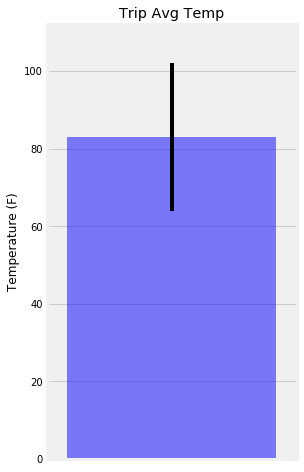

In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = tmax-tmin

bar = ax.bar(xpos, tmax, yerr=yerr, alpha=0.5, color='blue', align="center")
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Temperature (F)")
ax.margins(.1, .1)
fig.show()

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# note: used 2016 because there was no data for 2017 dates

trip_start = '2016-10-22'
trip_end = '2016-10-31'

sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results = session.query(*sel).filter(Measurement.station == Station.station).filter(Measurement.date >= trip_start).filter(Measurement.date <= trip_end).group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()

print(results)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 6.880000000000001), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.97), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.68), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.6000000000000001), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.4900000000000001), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.45999999999999996), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.42)]
